In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

#Spliting Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the directories containing human and non-human images
human_directory = "/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/humans"
nonhuman_directory = "/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/nonface"

# Output directories for train, test, and validate sets
train_directory = "/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/HOG/Train"
test_directory = "/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/HOG/Test"
val_directory = "/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/HOG/Val"

# Create output directories if they don't exist
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

# Function to split images into train, test, and validate sets
def split_images(source_directory, train_dir, test_dir, val_dir, test_size=0.1, val_size=0.2):
    # Get a list of all files in the source directory
    files = os.listdir(source_directory)

    # Split files into train and temp sets
    train_files, temp_files = train_test_split(files, test_size=(test_size + val_size))
    # Split temp files into test and val sets
    test_files, val_files = train_test_split(temp_files, test_size=(val_size / (test_size + val_size)))

    # Copy images to respective directories
    for file in train_files:
        shutil.copy(os.path.join(source_directory, file), os.path.join(train_dir, file))
    for file in test_files:
        shutil.copy(os.path.join(source_directory, file), os.path.join(test_dir, file))
    for file in val_files:
        shutil.copy(os.path.join(source_directory, file), os.path.join(val_dir, file))

# Split human images into train, test, and validate sets
split_images(human_directory, os.path.join(train_directory, "human"), os.path.join(test_directory, "human"), os.path.join(val_directory, "human"))

# Split non-human images into train, test, and validate sets
split_images(nonhuman_directory, os.path.join(train_directory, "nonhuman"), os.path.join(test_directory, "nonhuman"), os.path.join(val_directory, "nonhuman"))

print("Images split into train, test, and validate sets.")


In [12]:
def calculate_gradients(image):
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return gx, gy

def calculate_magnitude_orientation(gx, gy):
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * 180 / np.pi
    return magnitude, orientation

def create_histogram(orientation, magnitude, num_bins=9):
    bins = np.linspace(0, 180, num_bins + 1)
    hist, _ = np.histogram(orientation, bins=bins, weights=magnitude)
    return hist

def normalize_block(block):
    block_norm = np.sqrt(block.sum()**2 + 1e-5)
    return block / block_norm

def extract_hog_descriptor(image):
    gx, gy = calculate_gradients(image)
    magnitude, orientation = calculate_magnitude_orientation(gx, gy)

    cell_size = 8
    block_size = 2
    num_bins = 9

    descriptor = []
    for i in range(0, image.shape[0], cell_size):
        for j in range(0, image.shape[1], cell_size):
            cell_orientations = orientation[i:i+cell_size, j:j+cell_size]
            cell_magnitudes = magnitude[i:i+cell_size, j:j+cell_size]
            hist = create_histogram(cell_orientations, cell_magnitudes, num_bins)
            descriptor.extend(hist)

    descriptor = np.array(descriptor)
    descriptor = descriptor.reshape((descriptor.size // (block_size**2 * num_bins), block_size**2 * num_bins))

    for i in range(descriptor.shape[0]):
        for j in range(descriptor.shape[1]):
            descriptor[i, j] = normalize_block(descriptor[i, j])

    return descriptor.flatten()


In [9]:
def process_images_in_directory(directory_path):
    hog_descriptors = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"):  # Assuming images are in JPG format
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, (64, 128))  # Resize to a standard size

            hog_descriptor = extract_hog_descriptor(resized_image)
            hog_descriptors.append(hog_descriptor)

    return hog_descriptors

#human

In [ ]:
train_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Train/human')
val_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Val/human')
test_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Test/human')

# Convert to DataFrame and save as CSV
train_HOG_df = pd.DataFrame(train_HOGs)
val_HOG_df = pd.DataFrame(val_HOGs)
test_HOG_df = pd.DataFrame(test_HOGs)

train_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Trainhuman.csv', index=False)
val_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Valhuman.csv', index=False)
test_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Testhuman.csv', index=False)


In [ ]:
import pandas as pd

# Load the CSV file
df1 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Trainhuman.csv')

# Add a new column 'label' with the value 'human'
df1['label'] = 'human'

# Save the DataFrame back to a new CSV file
df1.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l1Trainhuman.csv', index=False)


In [ ]:
# Load the CSV file
df2 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Valhuman.csv')

# Add a new column 'label' with the value 'human'
df2['label'] = 'human'

# Save the DataFrame back to a new CSV file
df2.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l1Valhuman.csv', index=False)


In [ ]:
# Load the CSV file
df3 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Testhuman.csv')

# Add a new column 'label' with the value 'human'
df3['label'] = 'human'

# Save the DataFrame back to a new CSV file
df3.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l1Testhuman.csv', index=False)


#Non-human

In [ ]:
train_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Train/nonhuman')
val_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Val/nonhuman')
test_HOGs = process_images_in_directory('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Test/nonhuman')

# Convert to DataFrame and save as CSV
train_HOG_df = pd.DataFrame(train_HOGs)
val_HOG_df = pd.DataFrame(val_HOGs)
test_HOG_df = pd.DataFrame(test_HOGs)

train_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Trainnonhuman.csv', index=False)
val_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Valnonhuman.csv', index=False)
test_HOG_df.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Testnonhuman.csv', index=False)


In [ ]:
# Load the CSV file
df1 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Trainnonhuman.csv')

# Add a new column 'label' with the value 'human'
df1['label'] = 'nonhuman'

# Save the DataFrame back to a new CSV file
df1.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l2Trainnonhuman.csv', index=False)

# Load the CSV file
df2 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Valnonhuman.csv')

# Add a new column 'label' with the value 'nonhuman'
df2['label'] = 'nonhuman'

# Save the DataFrame back to a new CSV file
df2.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l2Valnonhuman.csv', index=False)

# Load the CSV file
df3 = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Testnonhuman.csv')

# Add a new column 'label' with the value 'human'
df3['label'] = 'nonhuman'

# Save the DataFrame back to a new CSV file
df3.to_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/l2Testnonhuman.csv', index=False)

#SVD

One-vs-Rest SVM classifier

In [ ]:
train_csv_path = '/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGTrain - Sheet1.csv'

# Load the CSV file into a Pandas DataFrame
train_df = pd.read_csv(train_csv_path)

# Load validation data
val_df = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGVal - Sheet1.csv')
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

# Standardize features
scaler = StandardScaler()
X_val_std = scaler.fit_transform(X_val)

# Define the parameter grid for GridSearchCV
param_grid = {
    'estimator__C': [1, 10, 100],  # You can specify other values as well
    'estimator__kernel': ['linear', 'rbf']  # Choose appropriate kernels
}

# Perform GridSearchCV to find the best parameters
svm = SVC(probability=True)
ovr_svm = OneVsRestClassifier(svm)
grid_search = GridSearchCV(ovr_svm, param_grid, cv=5)
grid_search.fit(X_val_std, y_val)

# Get the best parameters
best_C = grid_search.best_params_['estimator__C']
best_kernel = grid_search.best_params_['estimator__kernel']

# Train One-vs-Rest SVM classifier with best parameters using the combined train and validation data
X_train_combined = np.concatenate((train_df.drop('label', axis=1), X_val))
y_train_combined = np.concatenate((train_df['label'], y_val))
X_train_combined_std = scaler.transform(X_train_combined)

svm_classifier = OneVsRestClassifier(SVC(C=best_C, kernel=best_kernel, probability=True))
svm_classifier.fit(X_train_combined_std, y_train_combined)

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGTest - Sheet1.csv')
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Standardize test data
X_test_std = scaler.transform(X_test)

# Predict and evaluate on test data
y_pred = svm_classifier.predict(X_test_std)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f'Accuracy of One-vs-Rest SVM classifier on Test.csv: {accuracy_svm:.2f}')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Collect non-human images from any source with the same number as
the human and train a binary SVM for human vs. non-human (you can use the
sklearn library for SVM)

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

# Load train, validation, and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGTrain - Sheet1.csv')
val_df = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGVal - Sheet1.csv')
test_df = pd.read_csv('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/HOGTest - Sheet1.csv')

# Extract features (X) and labels (y) for train, validation, and test datasets
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_val, y_val = val_df.drop('label', axis=1), val_df['label']
X_test, y_test = test_df.drop('label', axis=1), test_df['label']

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = svm_classifier.predict(X_train)

# Calculate accuracy on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f'Accuracy on the training set: {accuracy_train:.2f}')

# Make predictions on the validation set
y_val_pred = svm_classifier.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred)
print(f'Accuracy on the validation set: {accuracy_val:.2f}')

# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on the test set: {accuracy_test:.2f}')


Accuracy on the training set: 1.00
Accuracy on the validation set: 0.57
Accuracy on the test set: 0.65


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
pip install joblib

In [4]:
import joblib

# Assuming svm_classifier is your trained SVM model
# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Save the trained SVM model to a .pkl file
joblib.dump(svm_classifier, '/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/svm_model.pkl')

print("SVM model saved as svm_model.pkl")

SVM model saved as svm_model.pkl


In [5]:

# Separate features and labels
features = test_df.drop('label', axis=1)

In [ ]:
labels = test_df['label']

# Plot box plots for each feature grouped by labels
for column in features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=labels, y=features[column])
    plt.xlabel('Label')
    plt.ylabel(column)
    plt.title(f'Distribution of {column} for human and nonhuman')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Compute the correlation matrix
correlation_matrix = features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


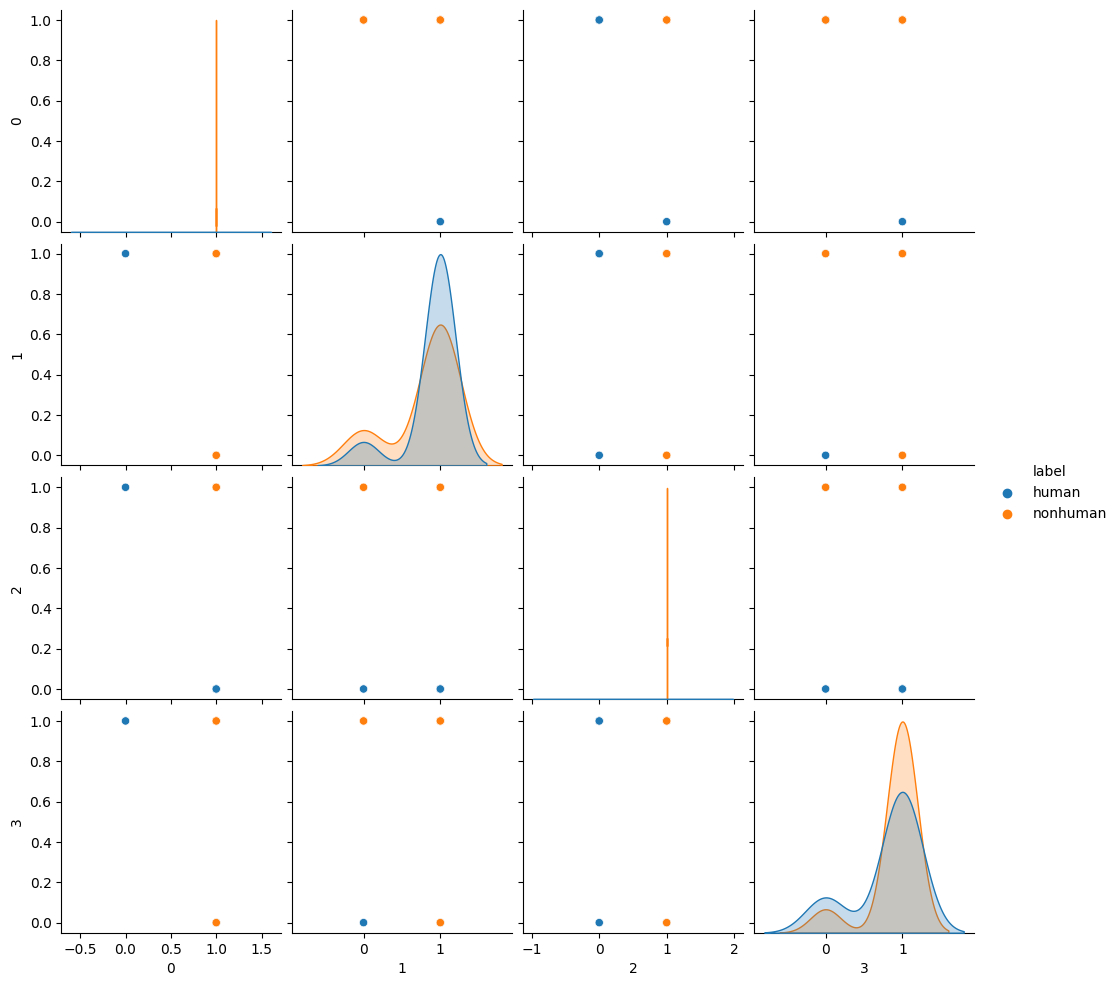

In [ ]:
# Select a subset of features for the pairplot
selected_features = ['0', '1', '2', '3']  # Choose the features you want to include

# Create the pairplot
sns.pairplot(test_df[selected_features + ['label']], hue='label', diag_kind='kde')
plt.show()


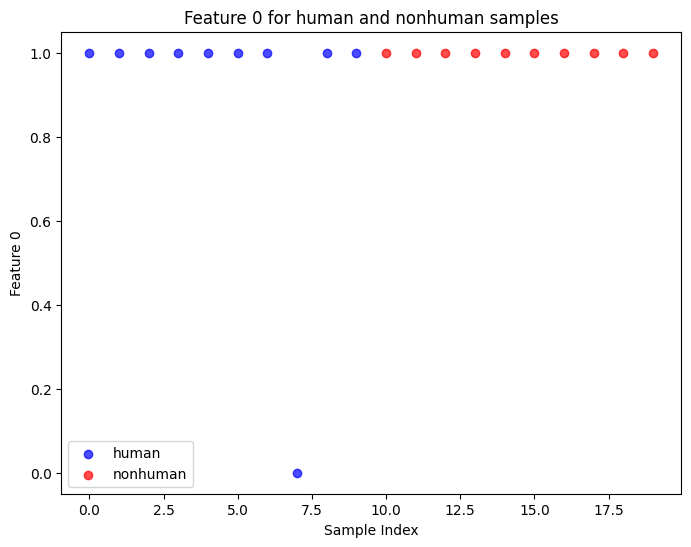

In [ ]:
import matplotlib.pyplot as plt

# Assuming your test data is loaded into a DataFrame called test_df
# Assuming the feature you want to visualize is '0' (you can change this to any other feature)

# Extract features and labels
feature_to_visualize = '0'
human_data = test_df[test_df['label'] == 'human'][feature_to_visualize]
nonhuman_data = test_df[test_df['label'] == 'nonhuman'][feature_to_visualize]

# Create a scatter plot for 'human' and 'nonhuman' samples
plt.figure(figsize=(8, 6))
plt.scatter(human_data.index, human_data.values, color='blue', label='human', alpha=0.7)
plt.scatter(nonhuman_data.index, nonhuman_data.values, color='red', label='nonhuman', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel(f'Feature {feature_to_visualize}')
plt.title(f'Feature {feature_to_visualize} for human and nonhuman samples')
plt.legend()
plt.show()


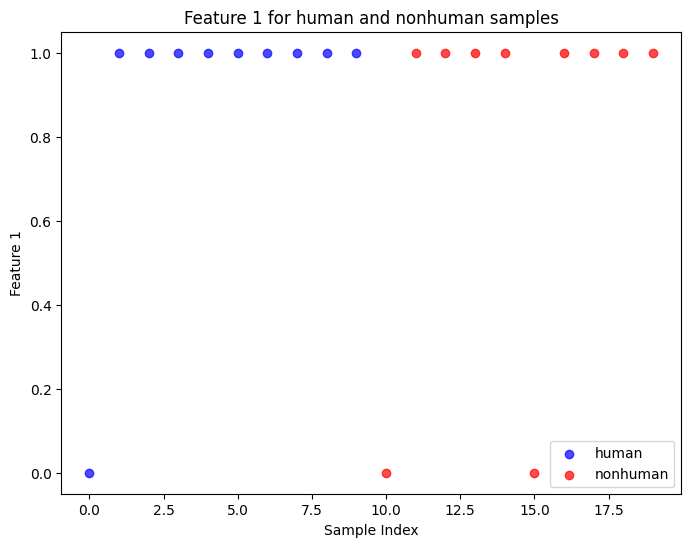

In [ ]:
# Extract features and labels
feature_to_visualize = '1'
human_data = test_df[test_df['label'] == 'human'][feature_to_visualize]
nonhuman_data = test_df[test_df['label'] == 'nonhuman'][feature_to_visualize]

# Create a scatter plot for 'human' and 'nonhuman' samples
plt.figure(figsize=(8, 6))
plt.scatter(human_data.index, human_data.values, color='blue', label='human', alpha=0.7)
plt.scatter(nonhuman_data.index, nonhuman_data.values, color='red', label='nonhuman', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel(f'Feature {feature_to_visualize}')
plt.title(f'Feature {feature_to_visualize} for human and nonhuman samples')
plt.legend()
plt.show()

In [6]:
import joblib

# Load the trained SVM model
svm_model = joblib.load('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/svm_model.pkl')


In [7]:
def sliding_window(image, step=20, window_size=(64, 64)):
    for y in range(0, image.shape[0] - window_size[1], step):
        for x in range(0, image.shape[1] - window_size[0], step):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])
window_size = (64, 64)  # You can adjust the window size according to your requirements


In [13]:
def detect_humans(image, window_size=(64, 64)):
    detected_humans = []
    for (x, y, window) in sliding_window(image, window_size=window_size):
        # Resize the window to match the SVM input size
        resized_window = cv2.resize(window, (64, 128))  # Assuming HOG features are extracted from this resized window

        # Extract HOG features from the window (you can use your HOG feature extraction function here)
        HOG_descriptor = extract_hog_descriptor(resized_window)

        # Classify the window using the SVM model
        prediction = svm_model.predict(HOG_descriptor.reshape(1, -1))

        # If SVM predicts human, add the window coordinates to the list of detected humans
        if prediction == 'human':
            detected_humans.append((x, y, x + window_size[0], y + window_size[1]))

    return detected_humans


In [15]:
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr

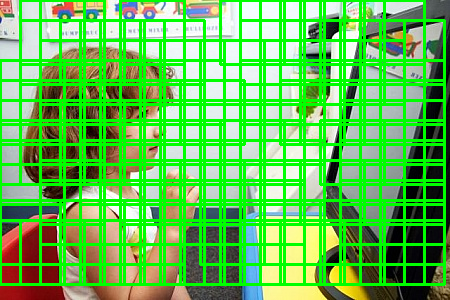

In [18]:
import cv2

# Load input image
input_image = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Test/human/image_131.jpg')

# Convert input image to grayscale if it's a color image
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Detect humans in the input image (assuming you have a function detect_humans that returns a list of bounding boxes)
detected_humans = detect_humans(gray_image)

# Draw rectangles around detected humans on the original image
for (x1, y1, x2, y2) in detected_humans:
    cv2.rectangle(input_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the output image with detected humans
cv2_imshow(input_image)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr

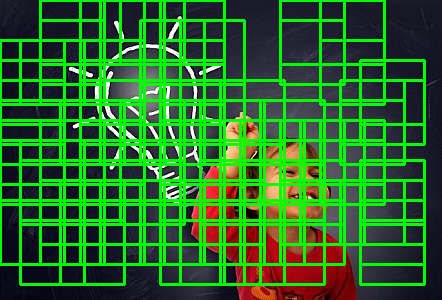

In [19]:
import cv2

# Load input image
input_image = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/Code2/HOG/Test/human/image_316.jpg')

# Convert input image to grayscale if it's a color image
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Detect humans in the input image (assuming you have a function detect_humans that returns a list of bounding boxes)
detected_humans = detect_humans(gray_image)

# Draw rectangles around detected humans on the original image
for (x1, y1, x2, y2) in detected_humans:
    cv2.rectangle(input_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the output image with detected humans
cv2_imshow(input_image)
